In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

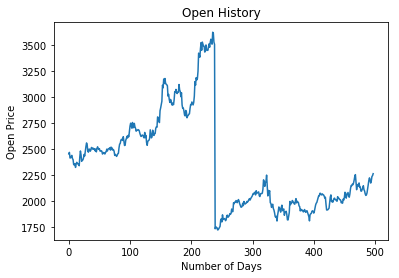

In [2]:
data = pd.read_csv("14-06-2017-TO-13-06-2019TCSALLN.csv")
y = np.array(data["Open Price"])
y = y[1:]
X = np.array(data[["Prev Close","High Price","Low Price","Last Price","Close Price","Total Traded Quantity","Turnover","No. of Trades","Deliverable Qty","% Dly Qt to Traded Qty","Average Price"]])
X = X[:X.shape[0]-1]
plt.figure()
plt.plot(data["Open Price"])
plt.title("Open History")
plt.xlabel("Number of Days")
plt.ylabel("Open Price")
plt.show()

In [3]:
def normalizeX(X):
    X = (X - np.min(X,axis = 0,keepdims = True))/(np.max(X,axis = 0,keepdims = True) - np.min(X,axis = 0,keepdims = True))
    return X
def normalizeY(Y_train,Y_test):
    a = np.max(Y_train)
    b = np.min(Y_train)
    Y_train = (Y_train - b)/(a - b)
    Y_test = (Y_test - b)/(a - b)
    return (Y_train, Y_test)
X = normalizeX(X)

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size = 0.2,shuffle = False)
Y_train, Y_test = normalizeY(Y_train,Y_test)
print(X_train.shape)
print(X_train[:2,:])
print(Y_train.shape)
print(X_test.shape)
print(X_test[:2,:])
print(Y_test.shape)

(397, 11)
[[0.38783805 0.38203    0.39961857 0.39327241 0.3977472  0.01593902
  0.0136246  0.08906136 0.01446578 0.6131     0.3898577 ]
 [0.3977472  0.37878241 0.37275706 0.36392531 0.36639923 0.03307985
  0.02782757 0.1349947  0.03614865 0.7612     0.36811447]]
(397,)
(100, 11)
[[0.0951331  0.10160318 0.0990115  0.09561647 0.09941023 0.05379366
  0.03555564 0.24792813 0.03346173 0.4382     0.09983956]
 [0.09941023 0.09451518 0.09608359 0.0920143  0.09579725 0.05486867
  0.03601271 0.38578408 0.04953804 0.6362     0.09286621]]
(100,)


In [5]:
X_train=X_train.T
X_test=X_test.T
print(X_train.shape)
print(X_test.shape)

(11, 397)
(11, 100)


In [6]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [7]:
def initialize_parameters(layers_dimensions):
    """
    layers_dimensions : list of number of activation units in each layer where first element is number of input dimensions.
    """
    parameters = {}
    np.random.seed(2)
    for i in range(len(layers_dimensions)-2):
        parameters["W_forget"+str(i+1)] = np.random.randn(layers_dimensions[i+1],layers_dimensions[i+1] + layers_dimensions[i])*np.sqrt(2/(layers_dimensions[i+1] + layers_dimensions[i]))
        parameters["W_input"+str(i+1)] = np.random.randn(layers_dimensions[i+1],layers_dimensions[i+1] + layers_dimensions[i])*np.sqrt(2/(layers_dimensions[i+1] + layers_dimensions[i]))
        parameters["W_output"+str(i+1)] = np.random.randn(layers_dimensions[i+1],layers_dimensions[i+1] + layers_dimensions[i])*np.sqrt(2/(layers_dimensions[i+1] + layers_dimensions[i]))
        parameters["W_c"+str(i+1)] = np.random.randn(layers_dimensions[i+1],layers_dimensions[i+1] + layers_dimensions[i])*np.sqrt(2/(layers_dimensions[i+1] + layers_dimensions[i]))
        parameters["b_forget"+str(i+1)] = np.zeros((layers_dimensions[i+1],1))
        parameters["b_input"+str(i+1)] = np.zeros((layers_dimensions[i+1],1))
        parameters["b_output"+str(i+1)] = np.zeros((layers_dimensions[i+1],1))
        parameters["b_c"+str(i+1)] = np.zeros((layers_dimensions[i+1],1))
    parameters["W_y"] = np.random.randn(layers_dimensions[-1],layers_dimensions[-2])*np.sqrt(2/(layers_dimensions[-2]))
    parameters["b_y"] = np.zeros((layers_dimensions[-1],1))
    return parameters

In [8]:
def initialize_like_parameters(parameters):
    d = {}
    for key in parameters.keys():
        d[key] = np.zeros(parameters[key].shape)
    return d

In [9]:
def lstm_forward_prop(X_train,Y_train,parameters,layers_dimensions):
    cache = {}
    T_x = X_train.shape[1]
    h_H = X_train
    cost = 0
    y_pred = []
    for j in range(len(layers_dimensions) - 2):
        c_t = np.zeros((layers_dimensions[j+1],1))
        h_t = np.zeros((layers_dimensions[j+1],1))
        temph_H = np.zeros((layers_dimensions[j+1],1))
        for i in range(T_x):
            h_X = np.concatenate((h_t,np.array(h_H[:,i]).reshape(h_H.shape[0],1)),axis=0)
            f_t = sigmoid(np.dot(parameters["W_forget"+str(j+1)],h_X) + parameters["b_forget"+str(j+1)])
            i_t = sigmoid(np.dot(parameters["W_input"+str(j+1)],h_X) + parameters["b_input"+str(j+1)])
            c_tilde_t = np.tanh(np.dot(parameters["W_c"+str(j+1)],h_X) + parameters["b_c"+str(j+1)])
            c_t = f_t*c_t + i_t*c_tilde_t
            o_t = sigmoid(np.dot(parameters["W_output"+str(j+1)],h_X) + parameters["b_output"+str(j+1)])
            h_t = o_t*np.tanh(c_t)
            temph_H = np.concatenate((temph_H,h_t),axis = 1)
            cache["L"+str(j+1)+"timestep"+str(i+1)] = [f_t,i_t,c_tilde_t,c_t,o_t,h_t,h_X]
        temph_H = temph_H[:,1:]
        h_H = temph_H
    for k in range(T_x):
        y_hat = np.dot(parameters["W_y"],h_H[:,k].reshape(h_H.shape[0],1)) + parameters["b_y"]
        y_pred.append(y_hat) 
        cost += (1/2)*np.square(Y_train[k] - y_hat)
    return (cost,cache,y_pred)     

In [10]:
def lstm_back_prop(cache,parameters,t_x,Y_train,y_pred,layers_dimensions):
    gradient = {}
    for key in parameters.keys():
        gradient["d"+ key] = np.zeros(parameters[key].shape)
    dX = []
    for k in range(t_x):
        dX.append((y_pred[k] - Y_train[k])*parameters["W_y"].T)
        gradient["dW_y"] += np.dot(y_pred[k] - Y_train[k],cache["L"+str(len(layers_dimensions)-2)+"timestep"+str(k+1)][5].T)
        gradient["db_y"] += y_pred[k] - Y_train[k]
    for j in range(len(layers_dimensions) - 2,0,-1):
        (dh_t,dc_t) = (np.zeros((layers_dimensions[j],1)),np.zeros((layers_dimensions[j],1)))
        dX_temp = []
        for i in range(t_x,0,-1):
            dh_t = dX[i - 1] + dh_t
            do_t = dh_t*np.tanh(cache["L"+str(j)+"timestep"+str(i)][3])*cache["L"+str(j)+"timestep"+str(i)][4]*(1 - cache["L"+str(j)+"timestep"+str(i)][4])
            dc_t = dh_t*cache["L"+str(j)+"timestep"+str(i)][4]*(1 - np.square(np.tanh(cache["L"+str(j)+"timestep"+str(i)][3]))) + dc_t
            dc_tilde_t = dc_t*cache["L"+str(j)+"timestep"+str(i)][1]*(1 - np.square(cache["L"+str(j)+"timestep"+str(i)][2]))
            di_t = dc_t*cache["L"+str(j)+"timestep"+str(i)][2]*cache["L"+str(j)+"timestep"+str(i)][1]*(1 - cache["L"+str(j)+"timestep"+str(i)][1])
            if i == 1:
                df_t = dc_t*np.zeros(df_t.shape)
            else:
                df_t = dc_t*cache["L"+str(j)+"timestep"+str(i - 1)][3]*cache["L"+str(j)+"timestep"+str(i)][0]*(1 - cache["L"+str(j)+"timestep"+str(i)][0])
            gradient["db_forget"+str(j)] += df_t
            gradient["db_input"+str(j)] += di_t
            gradient["db_c"+str(j)] += dc_tilde_t
            gradient["db_output"+str(j)] += do_t
            gradient["dW_forget"+str(j)] += np.dot(df_t,cache["L"+str(j)+"timestep"+str(i)][6].T)
            gradient["dW_input"+str(j)] += np.dot(di_t,cache["L"+str(j)+"timestep"+str(i)][6].T)
            gradient["dW_c"+str(j)] += np.dot(dc_tilde_t,cache["L"+str(j)+"timestep"+str(i)][6].T)
            gradient["dW_output"+str(j)] += np.dot(do_t,cache["L"+str(j)+"timestep"+str(i)][6].T)
            dh_X = np.zeros((layers_dimensions[j]+layers_dimensions[j-1],1))
            dh_X += np.dot(parameters["W_forget"+str(j)].T,df_t)
            dh_X += np.dot(parameters["W_input"+str(j)].T,di_t)
            dh_X += np.dot(parameters["W_output"+str(j)].T,do_t)
            dh_X += np.dot(parameters["W_c"+str(j)].T,dc_tilde_t)
            dX_temp.append(dh_X[layers_dimensions[j]:,:])
            dh_t = dh_X[:layers_dimensions[j],:]
            dc_t =  dc_t*cache["L"+str(j)+"timestep"+str(i)][0]
        dX = dX_temp
        dX.reverse()
    return gradient

In [11]:
def update_parameters(parameters,gradient,learning_rate,V,S,t,beta_1,beta_2):
    for key in V.keys():
        V[key] = beta_1*V[key] + (1 - beta_1)*gradient["d" + key]
        S[key] = beta_2*S[key] + (1 - beta_2)*np.square(gradient["d"+key])
        parameters[key] -= learning_rate*(V[key]/(1 - beta_1**t))*(1/np.sqrt(S[key]))
    return parameters,V,S

In [12]:
def train_model(X_train,Y_train,learning_rate,layers_dimensions,epochs = 50):
    input_dims = X_train.shape[0]
    t_x = X_train.shape[1]
    parameters = initialize_parameters(layers_dimensions)
    costs = []
    V = initialize_like_parameters(parameters)
    beta_1 = 0.9
    beta_2 = 0.998
    S = initialize_like_parameters(parameters)
    for i in range(epochs):
        cost,cache,Y_pred = lstm_forward_prop(X_train,Y_train,parameters,layers_dimensions)
        gradient = lstm_back_prop(cache,parameters,t_x,Y_train,Y_pred,layers_dimensions)
        parameters,V,S = update_parameters(parameters,gradient,learning_rate,V,S,i+1,beta_1,beta_2)
        cost = np.squeeze(cost)
        costs.append(cost)
        if i%100 == 0:
            print("Cost after "+ str(i)+" number of iterations: ",cost)
    return (parameters,costs)

In [13]:
print(X_train.shape)
print(Y_train.shape)
parameters,costs = train_model(X_train,Y_train,0.01,[11,10,10,1],1000)

(11, 397)
(397,)
Cost after 0 number of iterations:  40.75367522199282
Cost after 100 number of iterations:  1.0912249440535415
Cost after 200 number of iterations:  0.7322302894799732
Cost after 300 number of iterations:  0.6299321592020242
Cost after 400 number of iterations:  0.5771210244769538
Cost after 500 number of iterations:  0.5388717841468372
Cost after 600 number of iterations:  0.5084554720614165
Cost after 700 number of iterations:  0.4846011940421464
Cost after 800 number of iterations:  0.4671364913406908
Cost after 900 number of iterations:  0.45536188979040365


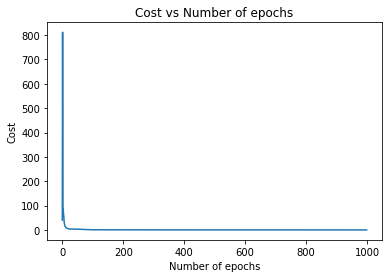

In [14]:
plt.figure()
plt.plot(costs)
#plt.figure(figsize = (18,10))
plt.xlabel("Number of epochs")
plt.ylabel("Cost")
plt.title("Cost vs Number of epochs")
plt.show()

In [15]:
def predict(parameters,X,Y_train,Y_test):
    Y = np.concatenate((Y_train,Y_test))
    X = X.T
    cost,cache,Y_pred = lstm_forward_prop(X,Y,parameters,[11,10,10,1]) 
    return np.squeeze(Y_pred)
Y_pred = predict(parameters,X,Y_train,Y_test)


Error on test set: 0.002993916195125097
(497,)


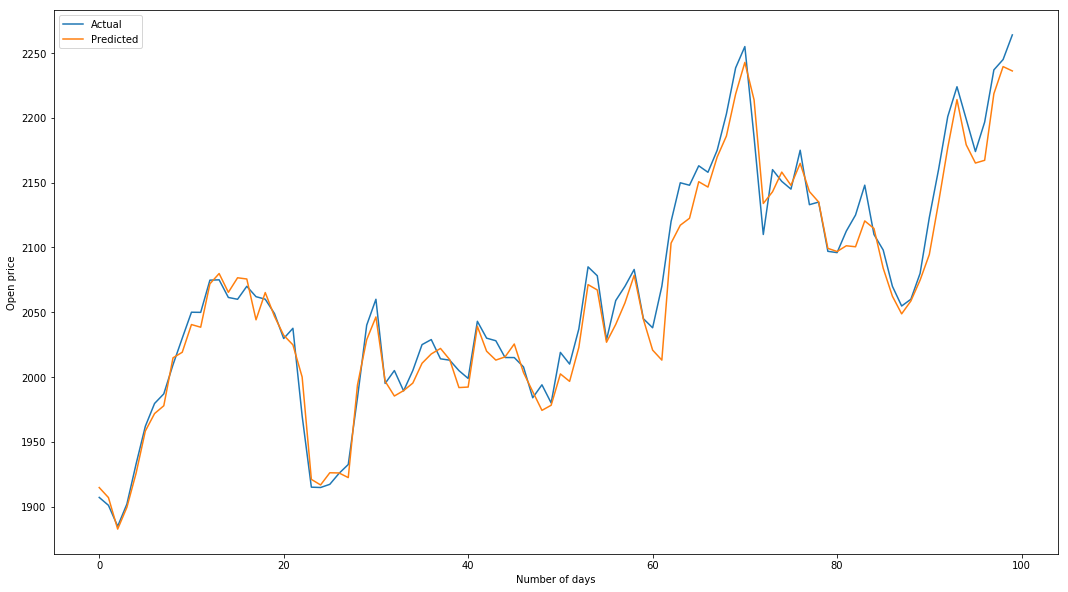

In [16]:
test_error = np.sum(np.square(Y_test - Y_pred[397:]))/2
print("Error on test set:",test_error)
Y_pred = np.array(Y_pred)*(np.max(y[:397]) - np.min(y[:397]))
Y_pred += np.min(y[:397])
print(Y_pred.shape)
plt.figure(figsize = (18,10))
plt.plot(y[397:],label = "Actual")
plt.plot(Y_pred[397:],label = "Predicted")
plt.xlabel("Number of days")
plt.ylabel("Open price")
plt.legend(loc = "best")
plt.show()

In [18]:
def gradient_check(X_train,Y_train,layers_dimensions):
    #np.random.seed(1)
    params = initialize_parameters(layers_dimensions)
    grad_approx = {}
    epsilon = 1e-7
    for key in params.keys():
        grad_approx[key] = np.zeros(params[key].shape)
        for i in range(params[key].shape[0]):
            for j in range(params[key].shape[1]):
                params[key][i][j] += epsilon
                cost1,cache,Y_pred = lstm_forward_prop(X_train,Y_train,params,layers_dimensions)
                params[key][i][j] -= 2*epsilon
                cost2,cache,Y_pred = lstm_forward_prop(X_train,Y_train,params,layers_dimensions)
                grad_approx[key][i][j] = (cost1 - cost2)/(2*epsilon)
                params[key][i][j] += epsilon
    cost,cache,Y_pred = lstm_forward_prop(X_train,Y_train,params,layers_dimensions)
    grad = lstm_back_prop(cache,params,X_train.shape[1],Y_train,Y_pred,layers_dimensions)
    grad_vec = np.zeros(1)
    grad_apx_vec = np.zeros(1)
    for key in grad.keys():
        grad_vec = np.concatenate((grad_vec,grad[key].reshape(grad[key].shape[0]*grad[key].shape[1])))
        #print(key + str(":"),grad[key])
        grad_apx_vec = np.concatenate((grad_apx_vec,grad_approx[key[1:]].reshape(grad_approx[key[1:]].shape[0]*grad_approx[key[1:]].shape[1])))
        #print(key + str(":"),grad_approx[key[1:]])
    grad_vec = grad_vec[1:]
    grad_apx_vec = grad_apx_vec[1:]
    numerator = np.linalg.norm(grad_vec - grad_apx_vec)
    denominator = (np.linalg.norm(grad_vec) + np.linalg.norm(grad_apx_vec))
    dist = numerator/denominator
    if dist <= epsilon:
        print("Gradient seems right")
    else:
        print("oops!!! Gradient seems wrong")
    return dist

In [ ]:
distance = gradient_check(X_train,Y_train,[11,10,1])
print("Normalized distance between gradient vectors(approximated and obtained from backpropagation:",distance)